# Geographic Hotspots: Correlation and Visual Analysis

This notebook loads a sample of the MTA Bus Automated Camera Enforcement Violations dataset and provides a correlation matrix, pairplot, and key visualizations for numeric and categorical variables.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a sample of the data (adjust path as needed)
df = pd.read_csv('/Users/test/MTA-Datathon/dataset-patterns/data/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922.csv', nrows=10000)

# Correlation matrix for numeric columns with more than one unique value
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if df[col].nunique() > 1]
if len(numeric_cols) < 2:
    print("Not enough numeric columns for correlation analysis.")
    print("Numeric columns found:", numeric_cols)
else:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Pairplot for numeric columns (if not too many)
    if 2 <= len(numeric_cols) <= 6:
        sns.pairplot(df[numeric_cols].dropna())
        plt.suptitle('Pairplot of Numeric Columns', y=1.02)
        plt.show()
    elif len(numeric_cols) > 6:
        print('Too many numeric columns for pairplot. Showing only first 5.')
        sns.pairplot(df[numeric_cols[:5]].dropna())
        plt.suptitle('Pairplot of First 5 Numeric Columns', y=1.02)
        plt.show()

# Bar plot for a top categorical variable (if available)
cat_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < 50 and df[col].nunique() > 1]
if cat_cols:
    top_cat = cat_cols[0]
    df[top_cat].value_counts().head(10).plot(kind='bar', figsize=(10,4))
    plt.title(f'Top 10 Values for {top_cat}')
    plt.ylabel('Count')
    plt.show()
else:
    print('No suitable categorical columns for bar plot.')

# Histogram for a top numeric variable (if available)
if numeric_cols:
    top_num = numeric_cols[0]
    df[top_num].hist(bins=30, figsize=(8,4))
    plt.title(f'Histogram of {top_num}')
    plt.xlabel(top_num)
    plt.ylabel('Frequency')
    plt.show()
else:
    print('No suitable numeric columns for histogram.')

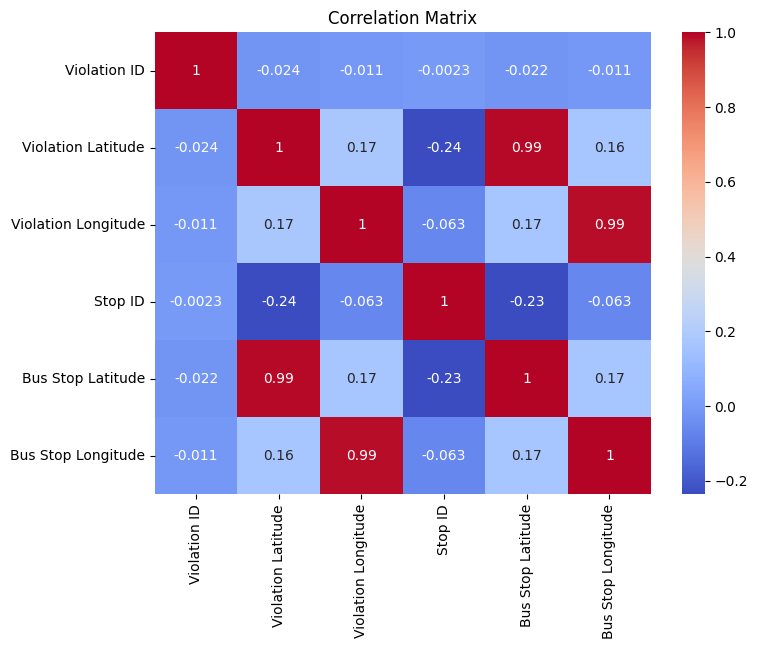

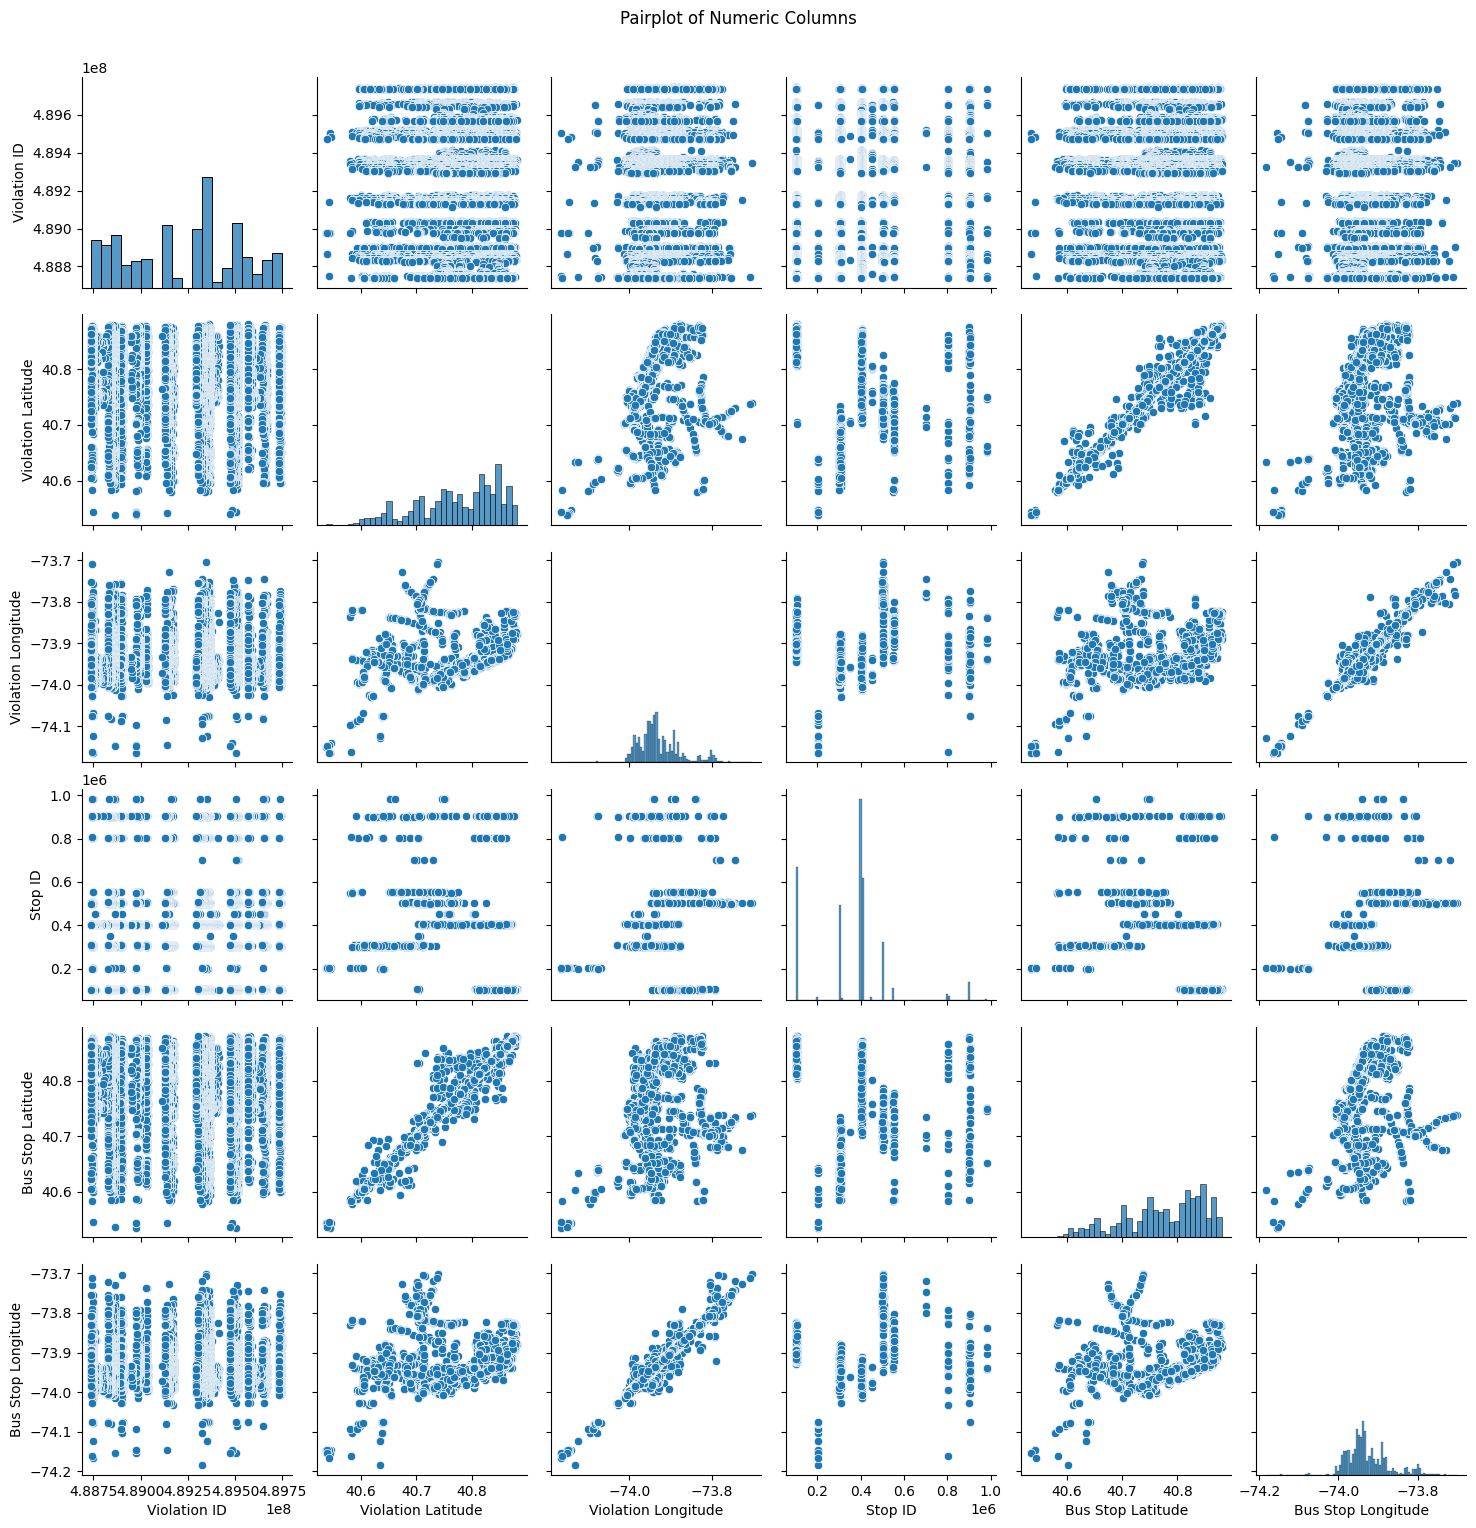

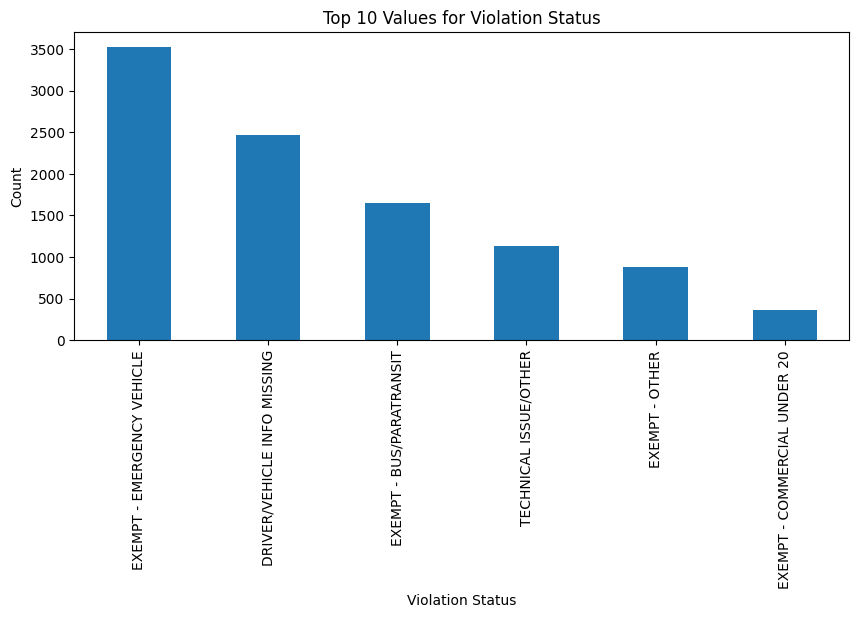

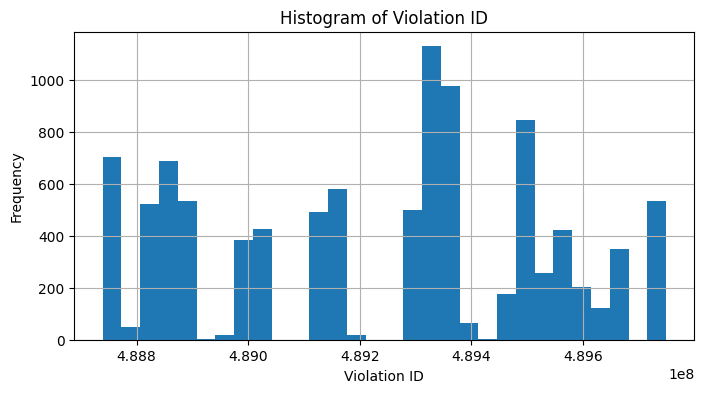

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a sample of the data (adjust path as needed)
df = pd.read_csv('/Users/test/MTA-Datathon/dataset-patterns/data/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250922.csv', nrows=10000)

# Correlation matrix for numeric columns with more than one unique value
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if df[col].nunique() > 1]
if len(numeric_cols) < 2:
    print("Not enough numeric columns for correlation analysis.")
    print("Numeric columns found:", numeric_cols)
else:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Pairplot for numeric columns (if not too many)
    if 2 <= len(numeric_cols) <= 6:
        sns.pairplot(df[numeric_cols].dropna())
        plt.suptitle('Pairplot of Numeric Columns', y=1.02)
        plt.show()
    elif len(numeric_cols) > 6:
        print('Too many numeric columns for pairplot. Showing only first 5.')
        sns.pairplot(df[numeric_cols[:5]].dropna())
        plt.suptitle('Pairplot of First 5 Numeric Columns', y=1.02)
        plt.show()

# Bar plot for a top categorical variable (if available)
cat_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < 50 and df[col].nunique() > 1]
if cat_cols:
    top_cat = cat_cols[0]
    df[top_cat].value_counts().head(10).plot(kind='bar', figsize=(10,4))
    plt.title(f'Top 10 Values for {top_cat}')
    plt.ylabel('Count')
    plt.show()
else:
    print('No suitable categorical columns for bar plot.')

# Histogram for a top numeric variable (if available)
if numeric_cols:
    top_num = numeric_cols[0]
    df[top_num].hist(bins=30, figsize=(8,4))
    plt.title(f'Histogram of {top_num}')
    plt.xlabel(top_num)
    plt.ylabel('Frequency')
    plt.show()
else:
    print('No suitable numeric columns for histogram.')